In [1]:
from src.preprocessing.preprocess_ucr import UCRDatasetImporter
from src.preprocessing.data_pipeline import build_data_pipeline
from src.utils import load_yaml_param_settings
from src.models.vqvae_representations import PretrainedVQVAE, BaseVQVAE
from src.experiments.tester import RepTester
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import torch
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

%matplotlib widget

Interesting datasets to look at:
1. CBF
2. Symbols
3. GunPointOldVersusYoung
4. Swedishleaf

do: pip3 install ipympl to view the 3d plots interactively

Define which dataset to analyse here:

In [2]:
dataset_analysis = 'CBF'

Loading vqvae and data

In [3]:
config_dir = 'src/configs/config.yaml' #dir to config file

config = load_yaml_param_settings(config_dir)

config['dataset']['dataset_name'] = dataset_analysis

# data pipeline
dataset_importer = UCRDatasetImporter(**config['dataset'])
batch_size = config['dataset']['batch_sizes']['vqvae']
train_data_loader, test_data_loader = [build_data_pipeline(batch_size, dataset_importer, config, kind) for kind in ['train', 'test']]

input_length = train_data_loader.dataset.X.shape[-1]

contrastive_vqvae = PretrainedVQVAE(input_length, config, contrastive=True)
vqvae = PretrainedVQVAE(input_length, config)

self.X_train.shape: (30, 128)
self.X_test.shape: (900, 128)
# unique labels (train): [0 1 2]
# unique labels (test): [0 1 2]
contrastive_encoder-CBF.ckpt loaded..
contrastive_decoder-CBF.ckpt loaded..
contrastive_vq_model-CBF.ckpt loaded..
encoder-CBF.ckpt loaded..
decoder-CBF.ckpt loaded..
vq_model-CBF.ckpt loaded..


grabbing zqs

In [4]:
zqs_train, s_train = contrastive_vqvae.run_through_encoder_codebook(train_data_loader)
zqs_train = torch.flatten(zqs_train, start_dim = 1).numpy()
y_train = train_data_loader.dataset.Y.flatten().astype(int)

zqs_test, s_test = contrastive_vqvae.run_through_encoder_codebook(test_data_loader)
zqs_test = torch.flatten(zqs_test, start_dim = 1).numpy()
y_test = test_data_loader.dataset.Y.flatten().astype(int)
#Umap density based

zqs = np.concatenate((zqs_test, zqs_train), axis=0)
y = np.concatenate((y_test, y_train), axis=0)

k = len(np.unique(y))

print("zqs_train shape:",zqs_train.shape)
print("zqs_test shape:",zqs_test.shape)
print("zqs shape:",zqs.shape)
print("y shape:", y.shape)

zqs_train shape: (30, 2560)
zqs_test shape: (900, 2560)
zqs shape: (930, 2560)
y shape: (930,)


## UMAP

In [5]:
import umap

dens_lam = 0.5

dens_mapper_2 = umap.UMAP(densmap=True, dens_lambda=dens_lam, n_components=2, random_state=42).fit(zqs)
dens_mapper_3 = umap.UMAP(densmap=True, dens_lambda=dens_lam, n_components=3, random_state=42).fit(zqs)

embs_train = umap.UMAP(densmap=True, dens_lambda=dens_lam, n_components=2, random_state=42).fit(zqs_train).embedding_
embs_test = umap.UMAP(densmap=True, dens_lambda=dens_lam, n_components=2, random_state=42).fit(zqs_test).embedding_

embs_2 = dens_mapper_2.embedding_
embs_3 = dens_mapper_3.embedding_

/home/erlendlokna/Documents/ntnu/representation-learning-VQ-VAE/.venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/erlendlokna/Documents/ntnu/representation-learning-VQ-VAE/.venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/erlendlokna/Documents/ntnu/representation-learning-VQ-VAE/.venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/erlendlokna/Docu

Text(0.5, 1.0, 'zqs train')

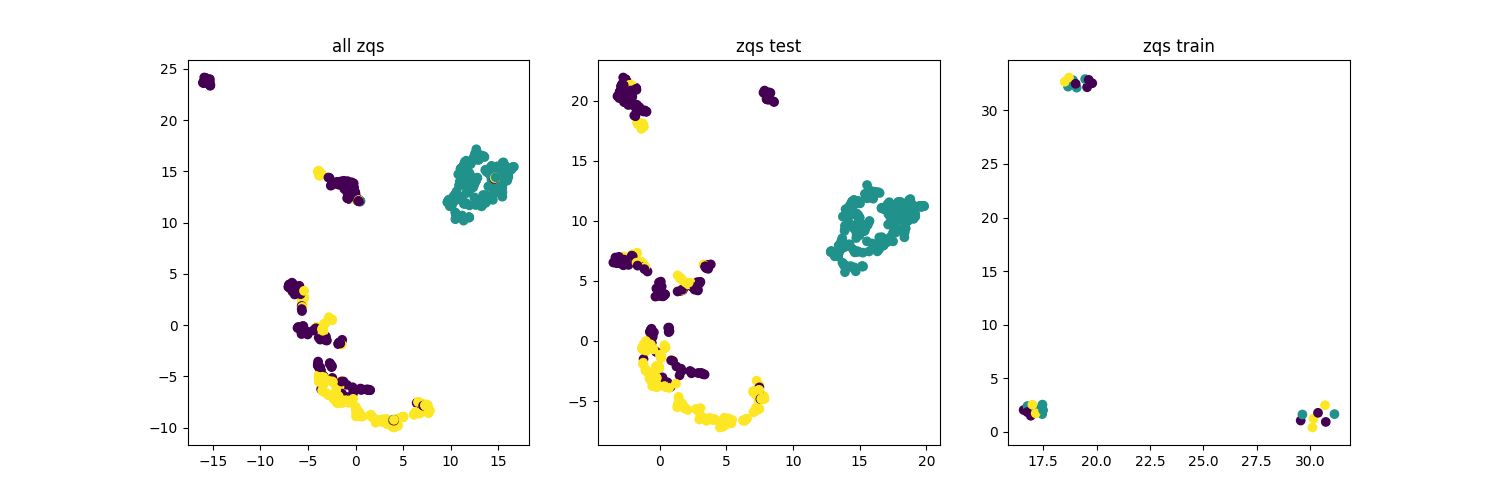

In [6]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(embs_2[:, 0], embs_2[:, 1], c=y); ax[0].set_title("all zqs")
ax[1].scatter(embs_test[:,0], embs_test[:,1], c=y_test); ax[1].set_title("zqs test")
ax[2].scatter(embs_train[:,0], embs_train[:,1], c=y_train); ax[2].set_title("zqs train")

Text(0.5, 1.0, 'zqs train')

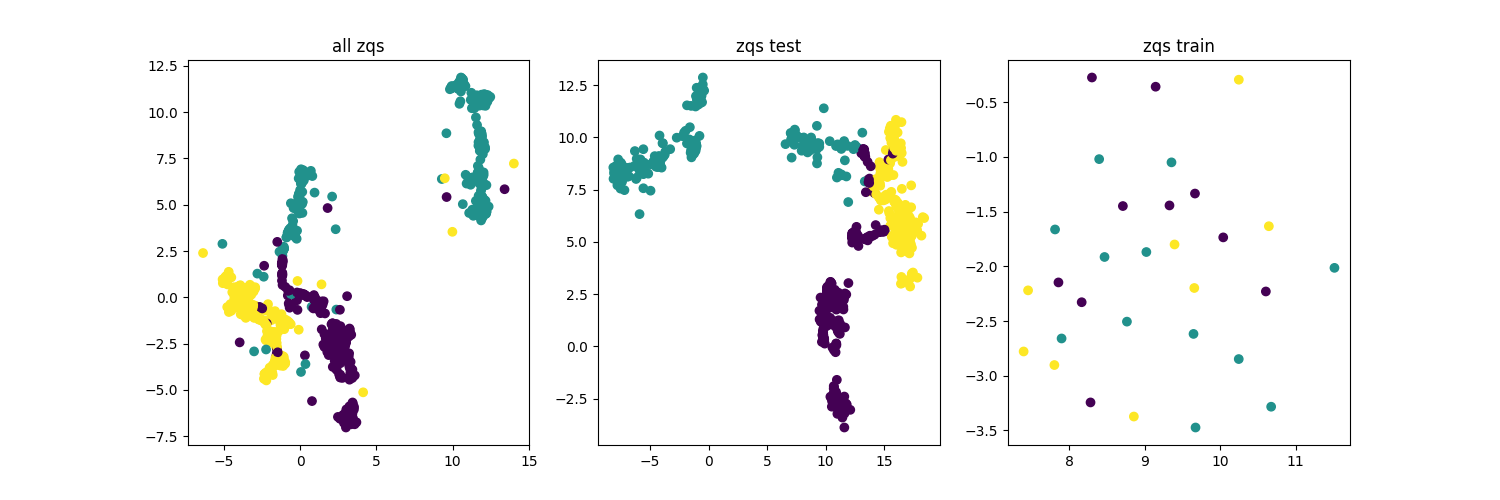

In [7]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(embs_2[:, 0], embs_2[:, 1], c=y); ax[0].set_title("all zqs")
ax[1].scatter(embs_test[:,0], embs_test[:,1], c=y_test); ax[1].set_title("zqs test")
ax[2].scatter(embs_train[:,0], embs_train[:,1], c=y_train); ax[2].set_title("zqs train")

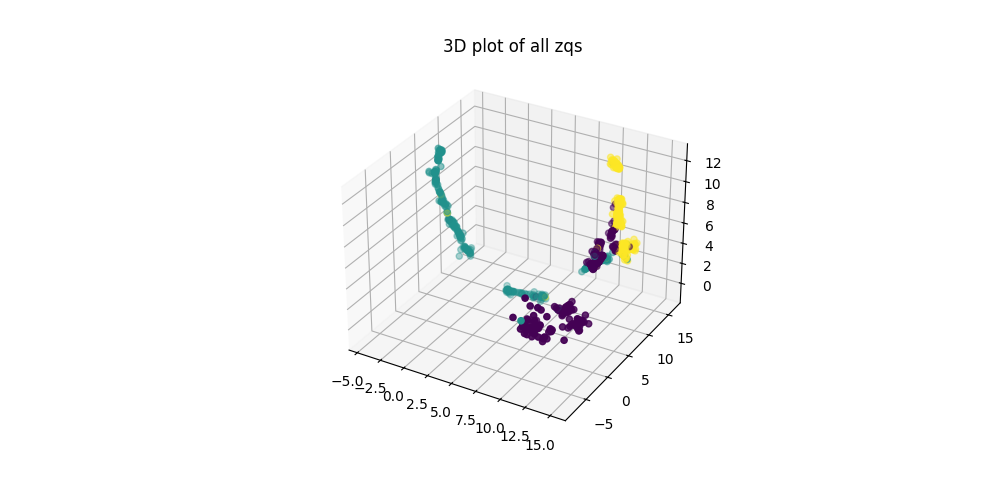

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embs_3[:, 0], embs_3[:, 1], embs_3[:, 2], c=y)
ax.set_title("3D plot of all zqs")
plt.show()

## T-SNE

In [7]:
from sklearn.manifold import TSNE

zqs_test_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs_test)
zqs_train_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs_train)
zqs_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs)
zqs_embedded3 = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs)

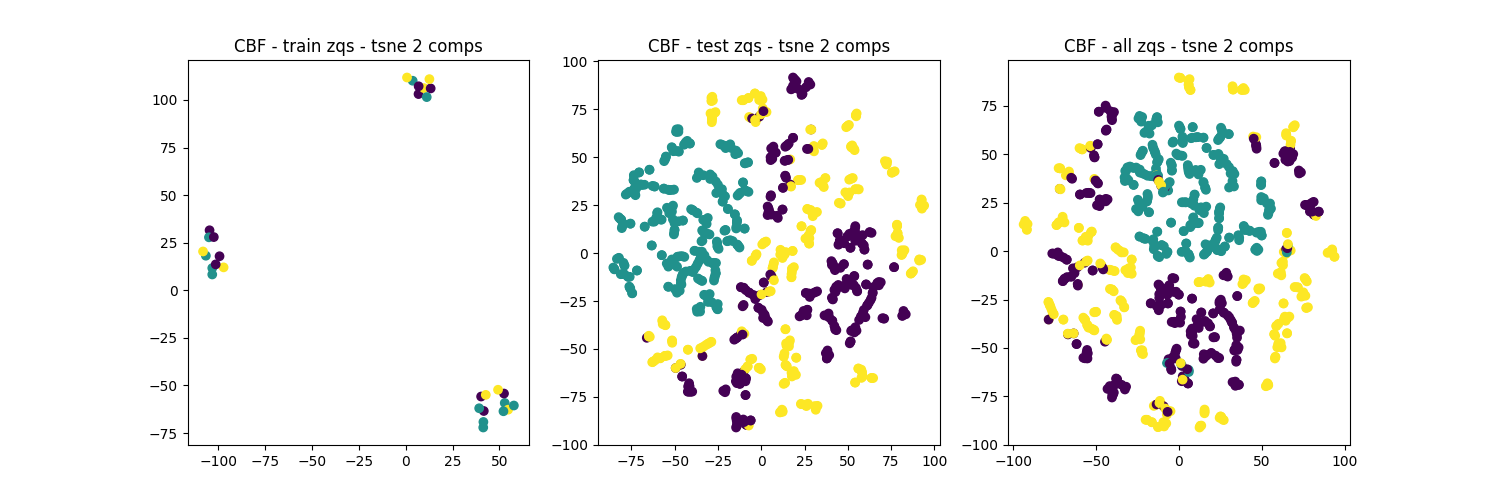

In [8]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(zqs_train_embedded2[:, 0], zqs_train_embedded2[:, 1], c=y_train); ax[0].set_title(f"{config['dataset']['dataset_name']} - train zqs - tsne 2 comps")
ax[1].scatter(zqs_test_embedded2[:, 0], zqs_test_embedded2[:, 1], c=y_test); ax[1].set_title(f"{config['dataset']['dataset_name']} - test zqs - tsne 2 comps")
ax[2].scatter(zqs_embedded2[:,0], zqs_embedded2[:,1], c=y); ax[2].set_title(f"{config['dataset']['dataset_name']} - all zqs - tsne 2 comps")
plt.show()

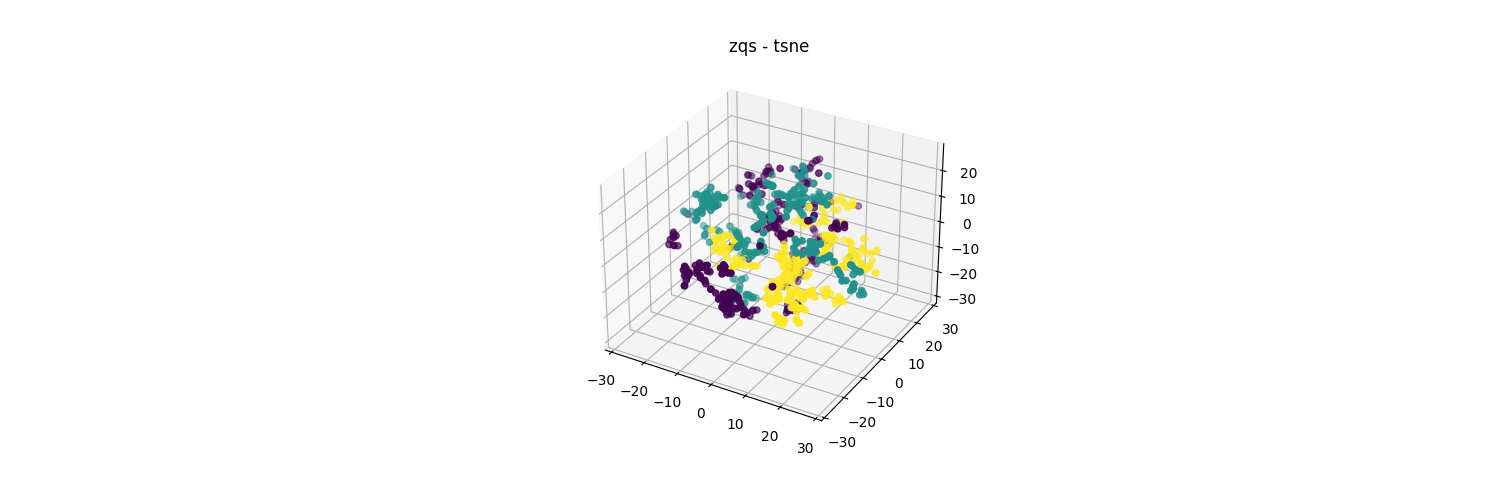

In [66]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zqs_embedded3[:, 0], zqs_embedded3[:, 1], zqs_embedded3[:, 2], c=y)
ax.set_title("zqs - tsne")
plt.show()

## PCA on discrete latent variables zq's


In [67]:
from sklearn.decomposition import PCA

pca2_test = PCA(n_components=2).fit(zqs_test)
pca2_train = PCA(n_components=2).fit(zqs_train)
pca2_all = PCA(n_components=2).fit(zqs)
pca3_all = PCA(n_components=3).fit(zqs)


print("sum variance explained test 2 comps:", sum(pca2_test.explained_variance_ratio_))
print("sum variance explained train 2 comps:", sum(pca2_train.explained_variance_ratio_))
print("sum variance explained all 2 comps:", sum(pca2_all.explained_variance_ratio_))
print("sum variance explained all 2 comps:", sum(pca3_all.explained_variance_ratio_))

sum variance explained test 2 comps: 0.6079907417297363
sum variance explained train 2 comps: 0.6244786828756332
sum variance explained all 2 comps: 0.6079461872577667
sum variance explained all 2 comps: 0.6938345432281494


In [68]:
zqs_test_2pc = pca2_test.transform(zqs_test)
zqs_train_2pc = pca2_train.transform(zqs_train)
zqs_all_2pc = pca2_all.transform(zqs)
zqs_all_3pc = pca3_all.transform(zqs)

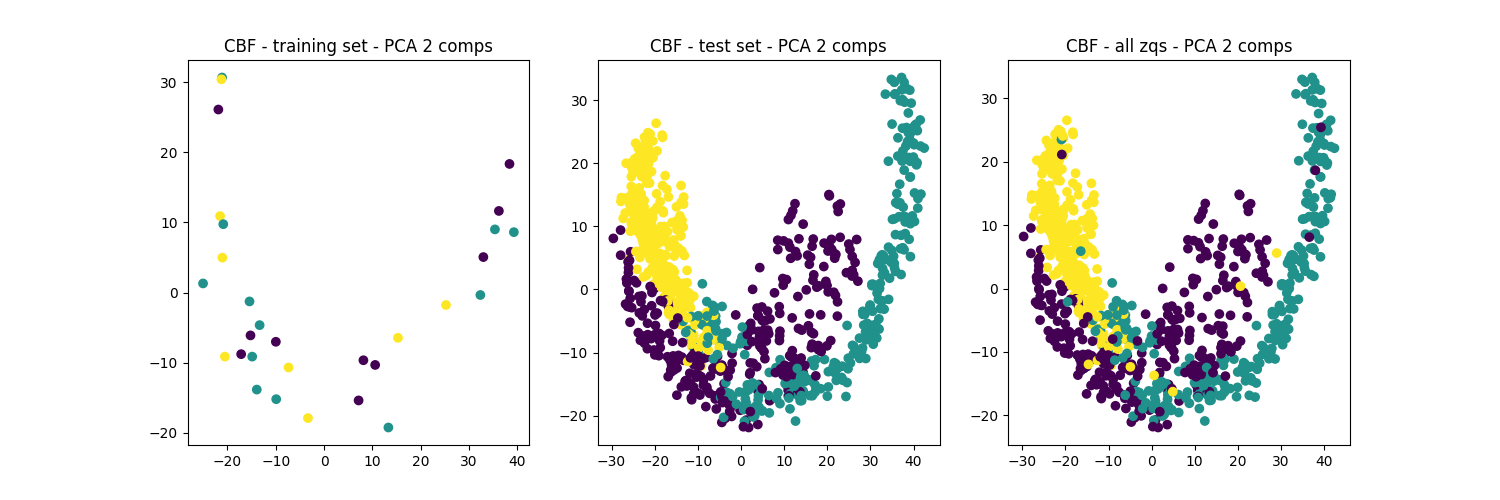

In [69]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(zqs_train_2pc[:, 0], zqs_train_2pc[:, 1], c=y_train); ax[0].set_title(f"{config['dataset']['dataset_name']} - training set - PCA 2 comps")
ax[1].scatter(zqs_test_2pc[:, 0], zqs_test_2pc[:, 1], c=y_test); ax[1].set_title(f"{config['dataset']['dataset_name']} - test set - PCA 2 comps")
ax[2].scatter(zqs_all_2pc[:, 0], zqs_all_2pc[:,1], c=y); ax[2].set_title(f"{config['dataset']['dataset_name']} - all zqs - PCA 2 comps")
plt.show()

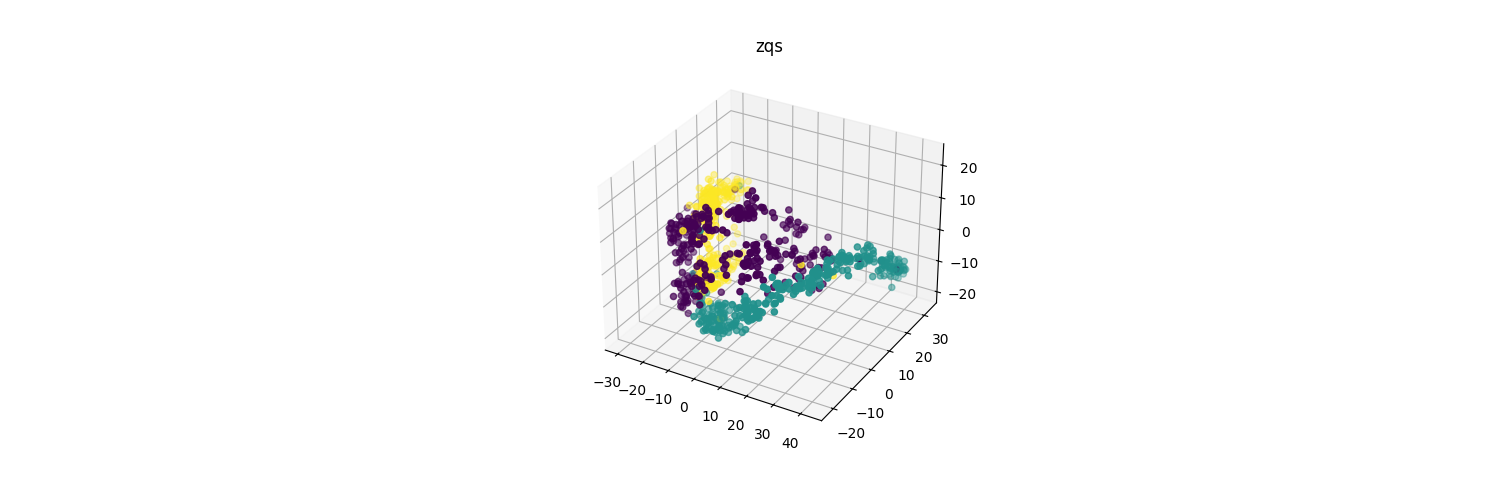

In [70]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zqs_all_3pc[:, 0], zqs_all_3pc[:, 1], zqs_all_3pc[:, 2], c=y)
ax.set_title("zqs")
plt.show()

## Codebook analysis

In [71]:
codebook = vqvae.get_codebook()

pca_codebook_3 = PCA(n_components=3).fit_transform(codebook)

pca_codebook_2 = PCA(n_components=2).fit_transform(codebook)

umap_codebook_2 = umap.UMAP(densmap=True, n_components=2).fit_transform(codebook)


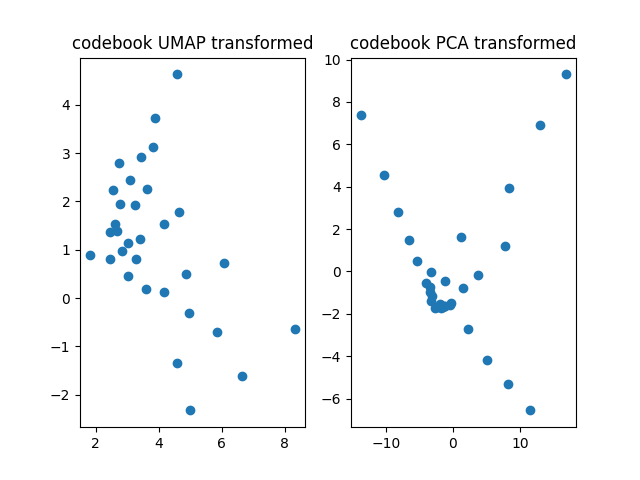

In [72]:
f, ax = plt.subplots(1, 2)
ax[0].scatter(umap_codebook_2[:, 0], umap_codebook_2[:, 1]); ax[0].set_title("codebook UMAP transformed")
ax[1].scatter(pca_codebook_2[:, 0], pca_codebook_2[:, 1]); ax[1].set_title("codebook PCA transformed")
plt.show()

## Pooling

In [17]:
tester = RepTester(vqvae, train_data_loader, test_data_loader)

In [42]:
import umap

zqs_conv1 = tester.conv2d_zqs(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=1)
zqs_conv2 = tester.flatten_zqs()

mapper = umap.UMAP(densmap=True, random_state=1)

zqs_test1 = mapper.fit_transform(zqs_conv1)
zqs_test2 = mapper.fit_transform(zqs_conv2)

/home/erlendlokna/Documents/ntnu/representation-learning-VQ-VAE/src/models/vqvae_representations.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zqs = torch.tensor(zqs, dtype=torch.float)
/home/erlendlokna/Documents/ntnu/representation-learning-VQ-VAE/.venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/erlendlokna/Documents/ntnu/representation-learning-VQ-VAE/.venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [43]:
print(zqs_conv1.shape)
print(zqs_conv2.shape)


(930, 960)
(930, 2560)


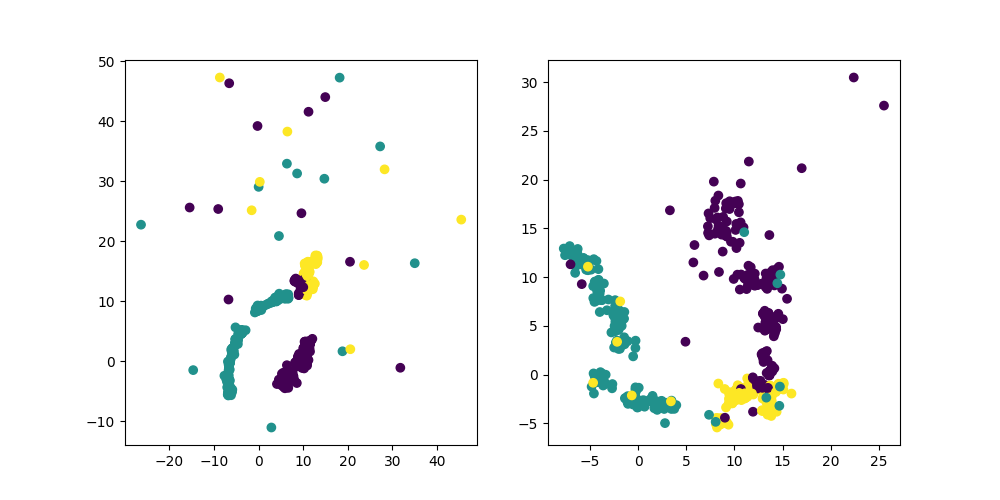

In [44]:
embs1 = zqs_test1
embs2 = zqs_test2

f, a = plt.subplots(1, 2, figsize=(10, 5))
a[0].scatter(embs1[:, 0], embs1[:, 1], c=tester.get_y())
a[1].scatter(embs2[:, 0], embs2[:, 1], c=tester.get_y())
plt.show()

In [ ]:
import umap

zqs_conv1 = tester.conv2d_zqs(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=1)
zqs_conv2 = tester.conv2d_zqs(in_channels=64, out_channels=12, kernel_size=2, stride=2, padding=1)

mapper = umap.UMAP(densmap=True, random_state=1)

embs1 = mapper.fit_transform(zqs_conv1)
embs2= mapper.fit_transform(zqs_conv2)